In [3]:
import numpy as np
import torch
from torch import optim
import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import get_train_val_loader, get_test_loader
from networks.cnn import CNN_pool, CNN_var
import matplotlib.pyplot as plt
import pyreadr
from scipy.integrate import quad
import scipy as sc

In [4]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    #result[:, 0] = -(1/0.25)*np.log(params[:,0])
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [5]:
def corr_func(h, method, r, s):
    if method=="brown":
        res = np.power((h/r),s)
    elif method=="powexp":
        res = np.exp(-np.power((h/r),s))        
    elif method == "whitmat":
        res = np.power(2, (1-s))/sc.special.gamma(s)*\
              np.power((h/r),2)*sc.special.kv(s, (h/r))
    return res    

In [6]:
def extremal_coefficient(h, method, r, s):
    if method=="brown":
        res = 2*sc.stats.norm.cdf(np.sqrt(corr_func(h, method, r, s))/2,loc = 0, scale = 1)    
    else:
        res = 1+np.sqrt(1-corr_func(h, method, r, s)/2)        
    return res    

In [7]:
def error_function(h, model, method, true, est):
    r_true, s_true = true
    r_est, s_est = est
    if method == "corr":
        error = np.power(corr_func(h, model, r_true, s_true)- corr_func(h, model, r_est, s_est),2)
    elif method =="ext":
        error = np.power(extremal_coefficient(h, model, r_true, s_true)- extremal_coefficient(h, model, r_est, s_est),2)
    return error

In [8]:
def get_imse(data, model, method):
    pred = data[0:2]
    params = data[2:4]
    error, _ = quad(error_function, 0, 40, args = (model, method, pred, params))
    return error

In [9]:
def get_metrics(pred, param, model):
    rmse = np.sqrt(np.mean((np.power(pred-param,2)), axis = 0))
    mae = np.mean(np.abs(pred-param), axis = 0)
    bias = np.mean(pred-param, axis = 0)
    imse_ext = np.mean(np.array([get_imse(x, model, "ext") for x in np.append(pred, param, axis = 1)]))
    
    
    print(f"RMSE: {np.round(rmse,2)}")
    #print(f"MAE: {np.round(mae,2)}")
    print(f"Ext - IMSE: {np.round(imse_ext,4)}")
    
    #print(f"Bias: {np.round(bias,2)}")

# Results for Brown-Resnick with new parameter range

## PL

In [10]:
exp = "exp_5"
path = f'../data/{exp}/data/'
brown_params = pyreadr.read_r(path+"brown_test_params.RData")["test_params"].to_numpy()
schlather_params = pyreadr.read_r(path+"powexp_test_params.RData")["test_params"].to_numpy()
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_single_image_fit_opt.RData")["results"].to_numpy()
schlather_res = pyreadr.read_r(path+"powexp_single_image_fit_opt.RData")["results"].to_numpy()[:,1:]

PyreadrError: File b'../data/exp_5/results/brown_single_image_fit_opt.RData' does not exist!

In [19]:
get_metrics(brown_res, brown_params, "brown")

RMSE: [0.69 0.36]
MAE: [0.49 0.3 ]
Corr - IMSE: 206949.04
Ext - IMSE: 0.7113


In [20]:
get_metrics(schlather_res, schlather_params, "powexp")

RMSE: [1.25 0.56]
MAE: [1.04 0.46]
Corr - IMSE: 0.64
Ext - IMSE: 0.0455


In [13]:
# Dataloader
path = f"../data/{exp}/data/"
model = "brown"
dataloader, _ = get_test_loader(data_path = path, model = model, batch_size = 1000)

In [15]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn.pt"))

<All keys matched successfully>

In [16]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [17]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [18]:
# Brown metrics
get_metrics(pred_tf,param_tf, model)

RMSE: [0.52 0.26]
Ext - IMSE: 0.2575


In [19]:
# Plot results
n_comb = 25
n_each = 20

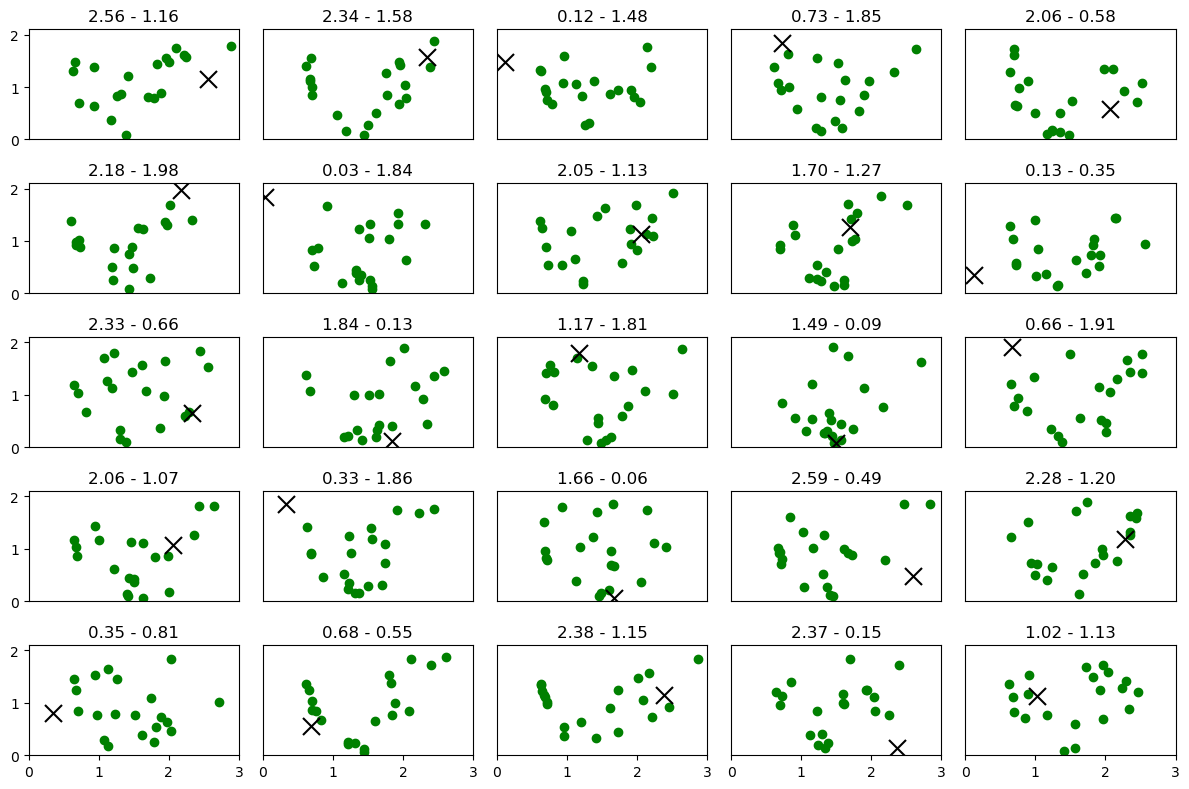

In [20]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2.1])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

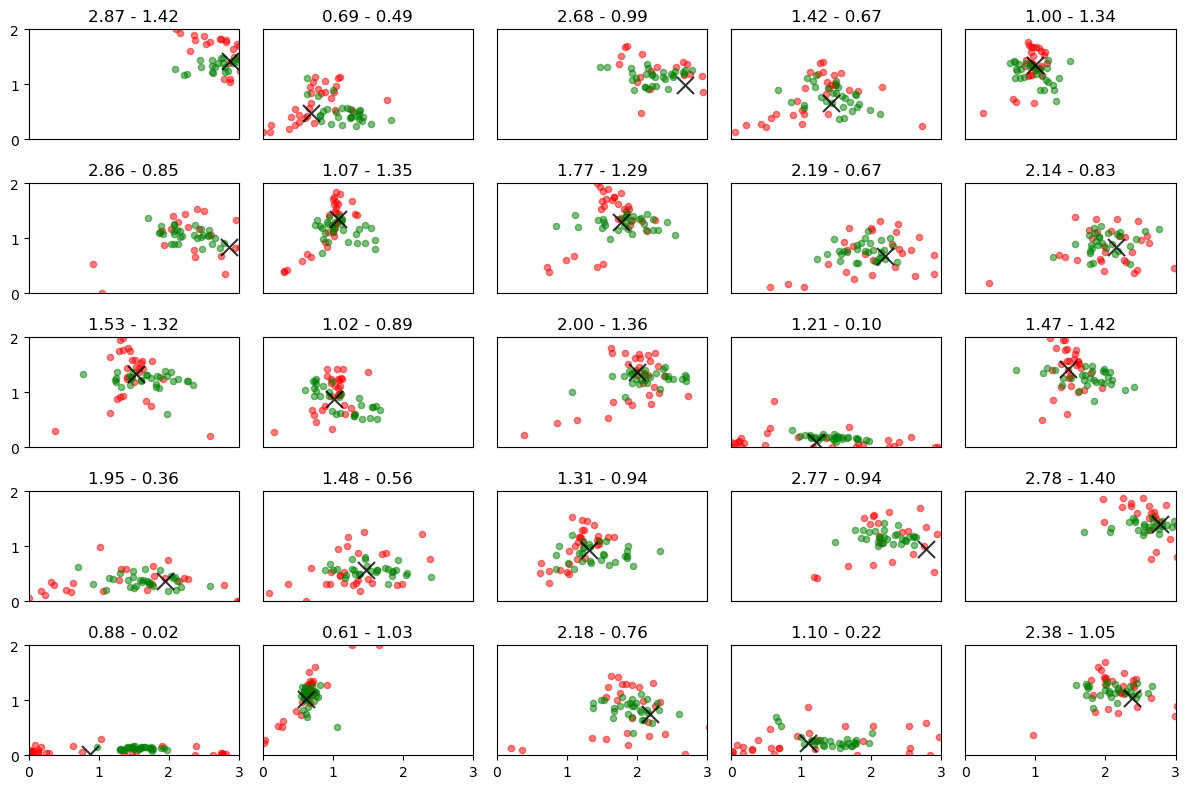

In [37]:
# With Likelihood fixed range

range_1 = 3
range_2 = 2
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*n_each):((i+1)*n_each),0], y = brown_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_xlim([0,range_1])
    axs[i].set_ylim([0,range_2])
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

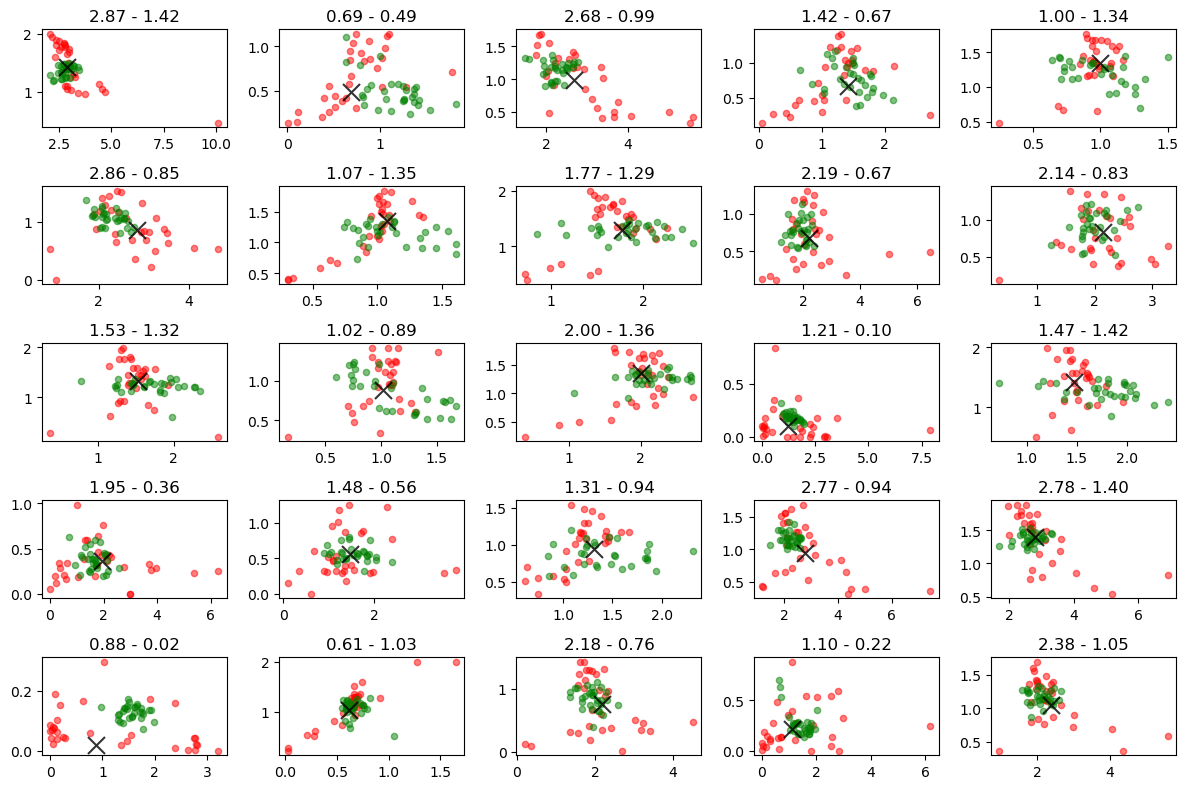

In [38]:
# With Likelihood flexible range
n_comb = 25
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*n_each):((i+1)*n_each),0], y = brown_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

# Results for schlather with new parameter range

In [59]:
# Dataloader
exp = "exp_5"
path = f"../data/{exp}/data/"
model = "whitmat"
dataloader, _ = test_loader(data_path = path, model = model, batch_size = 1000)

In [54]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [55]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [56]:
pred_tf = retransform(pred)
param_tf = retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [57]:
# Schlather metrics
get_metrics(pred_tf,param_tf, model)

RMSE: [0.63 0.48]
Ext - IMSE: 0.0098


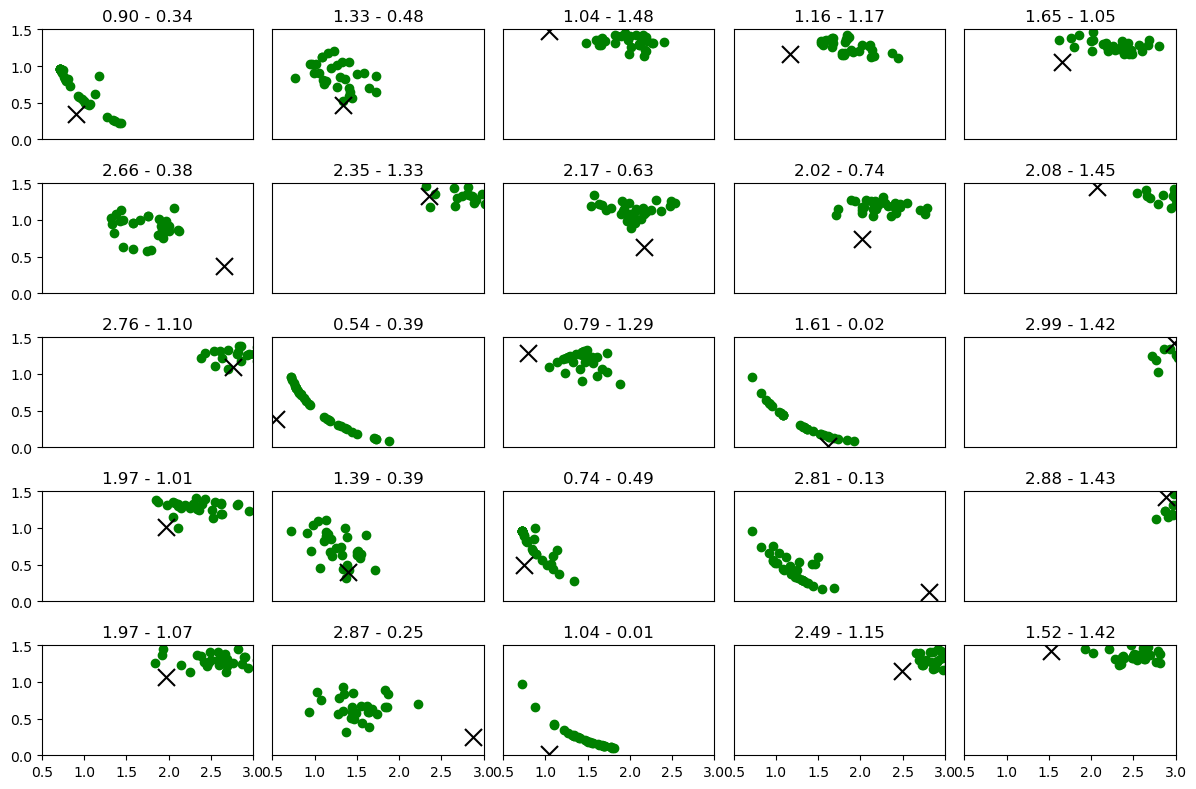

In [129]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,1.5])
    axs[i].set_xlim([0.5,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

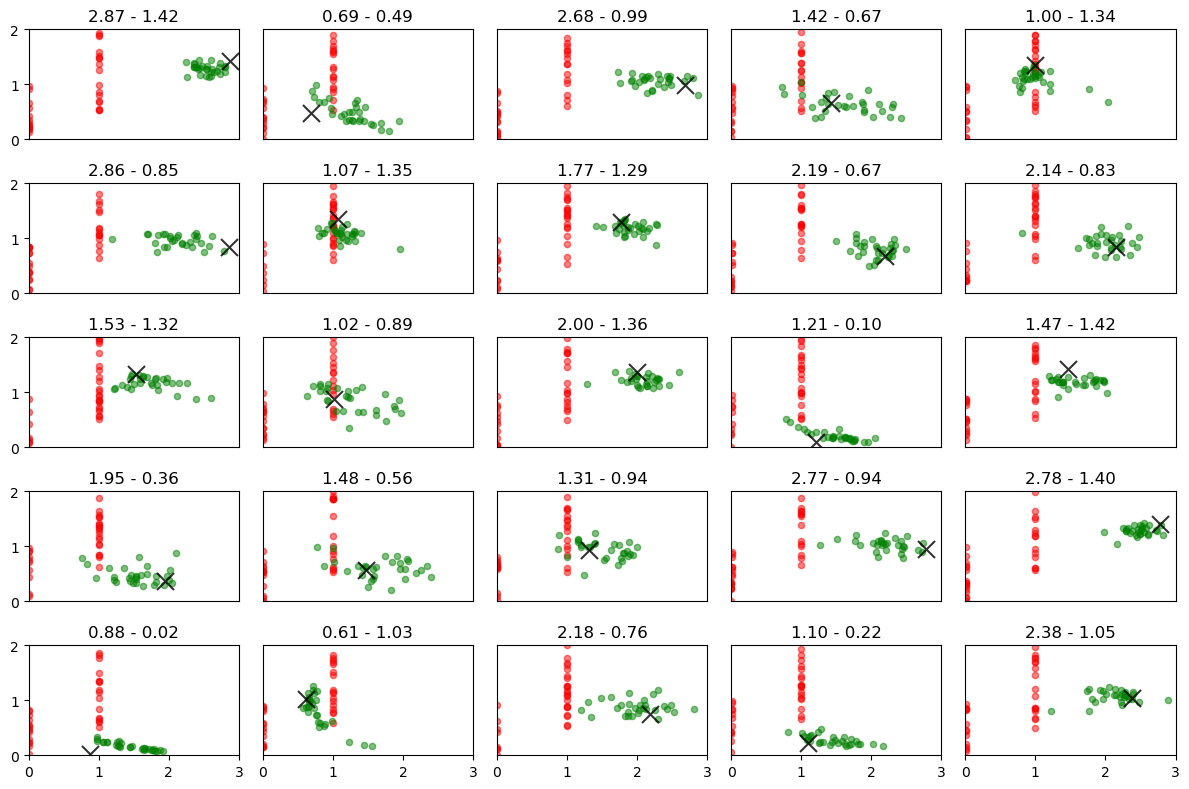

In [45]:
# With Likelihood fixed range

range_1 = 3
range_2 = 2
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*n_each):((i+1)*n_each),0], y = schlather_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_xlim([0,range_1])
    axs[i].set_ylim([0,range_2])
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

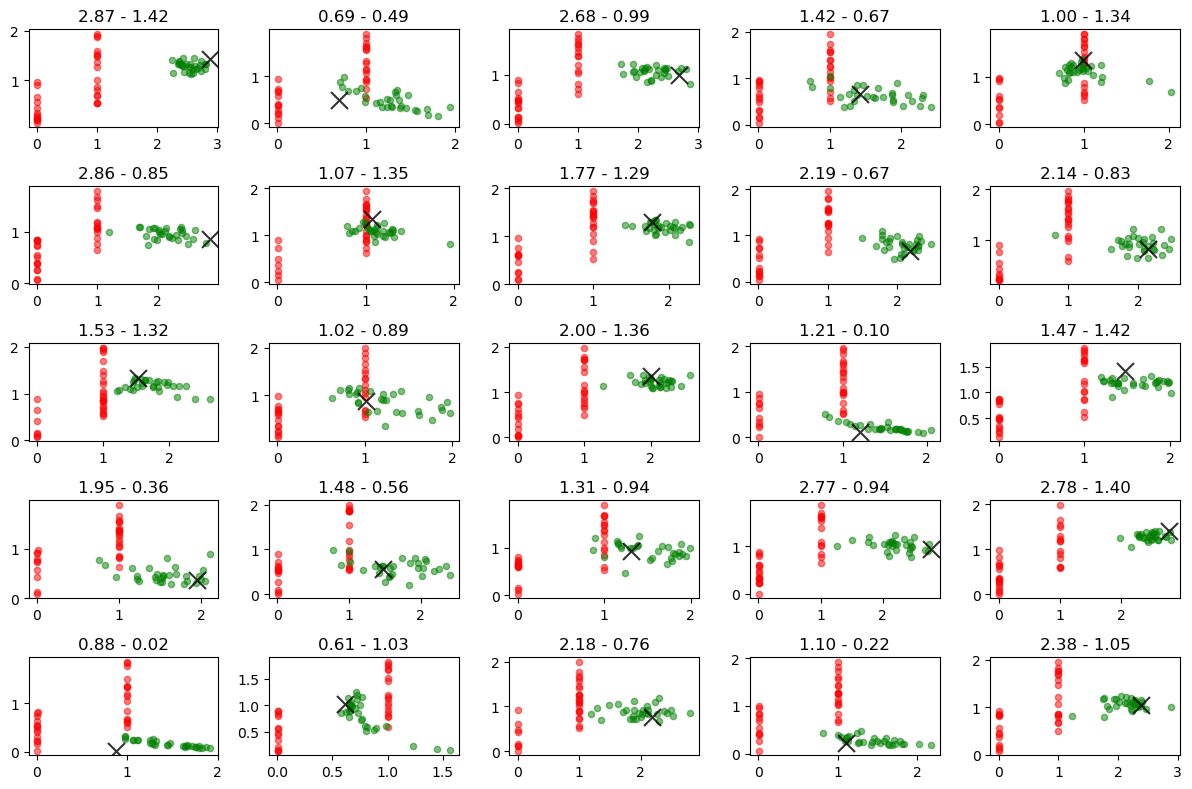

In [46]:
# With Likelihood flexible range
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*n_each):((i+1)*n_each),0], y = schlather_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)   
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

# Results for outside parameters

In [85]:
exp = "exp_4"
path = f'../data/{exp}/data/'
brown_params = pyreadr.read_r(path+"brown_test_params_outside.RData")["test_params"].to_numpy()
schlather_params = pyreadr.read_r(path+"powexp_test_params_outside.RData")["test_params"].to_numpy()
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_single_image_fit_opt_outside.RData")["results"].to_numpy()
schlather_res = pyreadr.read_r(path+"powexp_single_image_fit_opt_outside.RData")["results"].to_numpy()[:,1:]

In [86]:
# Dataloader
exp = "exp_4"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, dataset = test_loader(data_path = path, model = model, batch_size = 750)

In [87]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [88]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [89]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [90]:
# Brown metrics CNN
get_metrics(pred_tf,param_tf, "brown")

RMSE: [1.66 0.61]
MAE: [1.42 0.48]
Corr - IMSE: 776160.77
Ext - IMSE: 1.45


In [66]:
# Brown metrics PL
get_metrics(brown_res, brown_params, "brown")

RMSE: [1.36 0.39]
MAE: [0.84 0.26]
Corr - IMSE: 5847737345.87
Ext - IMSE: 0.57


In [67]:
# Plot results
n_comb = 8
n_each = 50

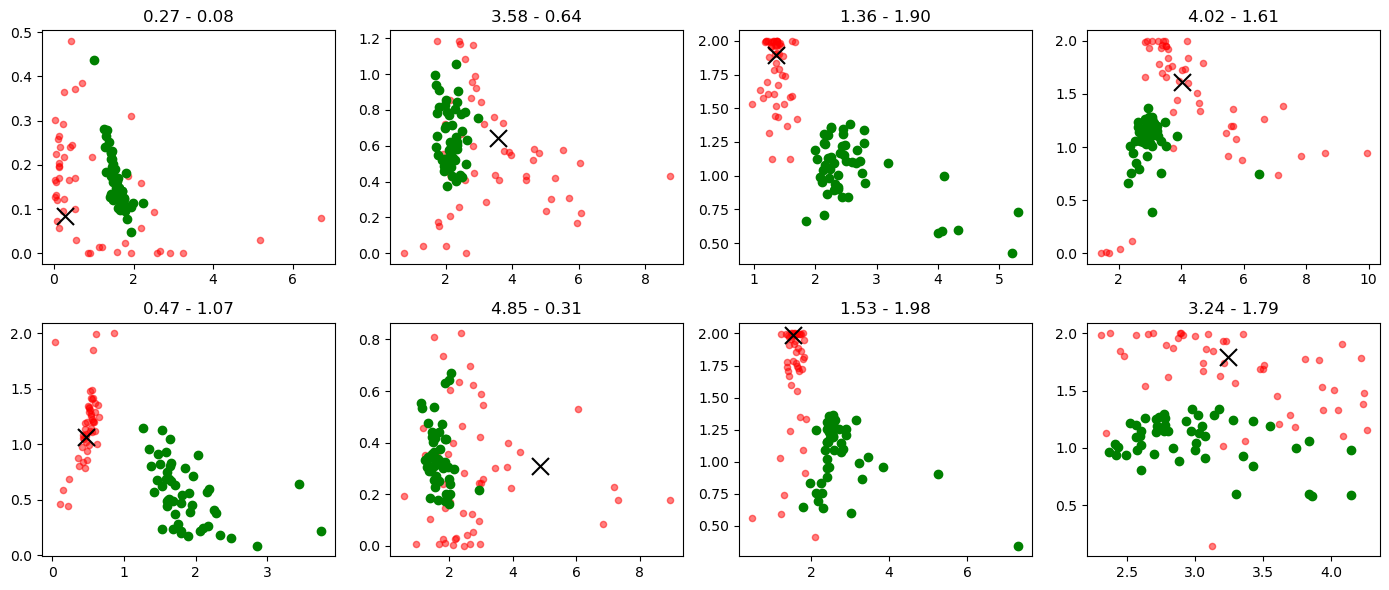

In [68]:
fig, axs = plt.subplots(2,4,figsize = (14,6))
axs = axs.transpose().ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*n_each):((i+1)*n_each),0], y = brown_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

In [77]:
# Dataloader
exp = "exp_4"
path = f"../data/{exp}/data/"
model = "powexp"
dataloader, dataset = test_loader(data_path = path, model = model, batch_size = 750)

In [78]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [79]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [80]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [81]:
# Schlather metrics
get_metrics(pred_tf,param_tf, "powexp")

RMSE: [1.42 0.58]
MAE: [1.21 0.46]
Corr - IMSE: 0.54
Ext - IMSE: 0.04


In [82]:
get_metrics(schlather_res, schlather_params, "powexp")

RMSE: [2.49 0.88]
MAE: [1.99 0.73]
Corr - IMSE: 1.18
Ext - IMSE: 0.09


In [83]:
# Plot results
n_comb = 8
n_each = 50

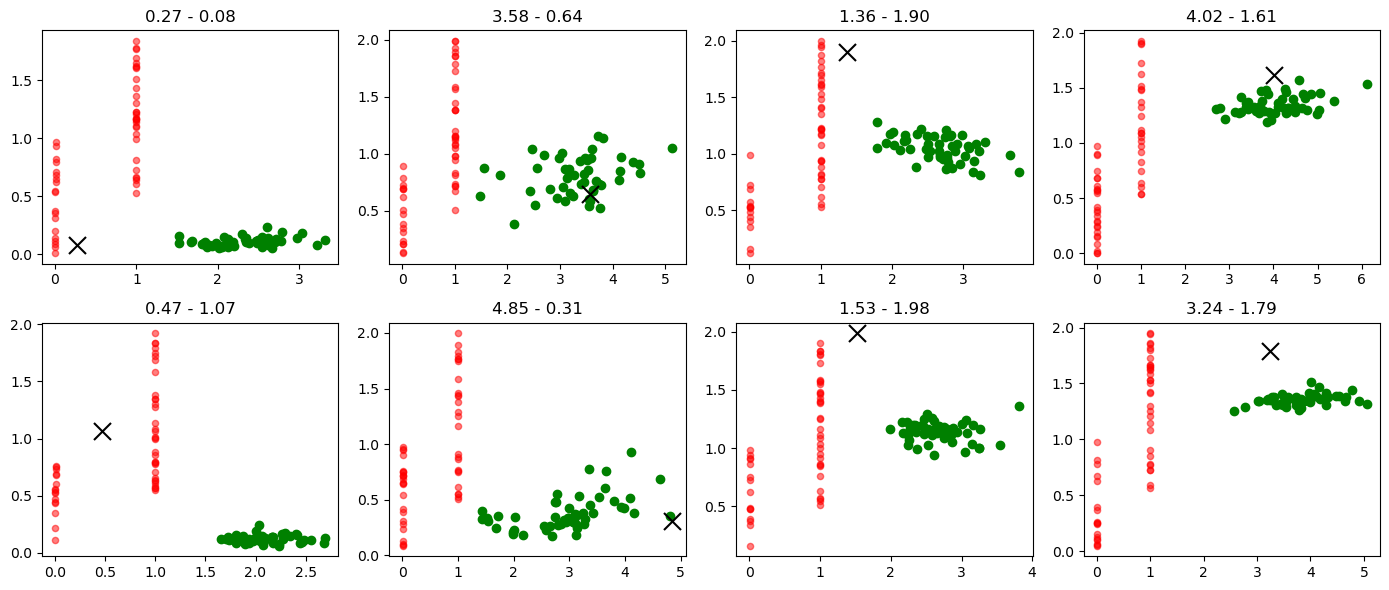

In [84]:
fig, axs = plt.subplots(2,4,figsize = (14,6))
axs = axs.transpose().ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*n_each):((i+1)*n_each),0], y = schlather_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

# Results for aggregated model

In [8]:
# Dataloader
exp = "exp_4"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, _ = test_loader(data_path = path, model = "brown", batch_size = 2250)

In [9]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/combined_cnn_pool.pt"))

<All keys matched successfully>

In [10]:
for sample in dataloader:
    img, param, model = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()
model = model.detach().numpy()

In [12]:
pred_tf_full = retransform(pred)
param_tf_full = retransform(param)

In [16]:
# Powexp metrics
get_metrics(pred_tf_full[model==1],param_tf_full[model==1], "powexp")

RMSE: [0.5  0.28]
MAE: [0.4  0.22]
Corr - IMSE: 0.16
Ext - IMSE: 0.0114


In [17]:
# Whitmat metrics
get_metrics(pred_tf_full[model==2],param_tf_full[model==2], "whitmat")

RMSE: [0.61 0.25]
MAE: [0.46 0.21]
Corr - IMSE: 0.14
Ext - IMSE: 0.0106


In [12]:
# Plot results
n_comb = 25
n_each = 30

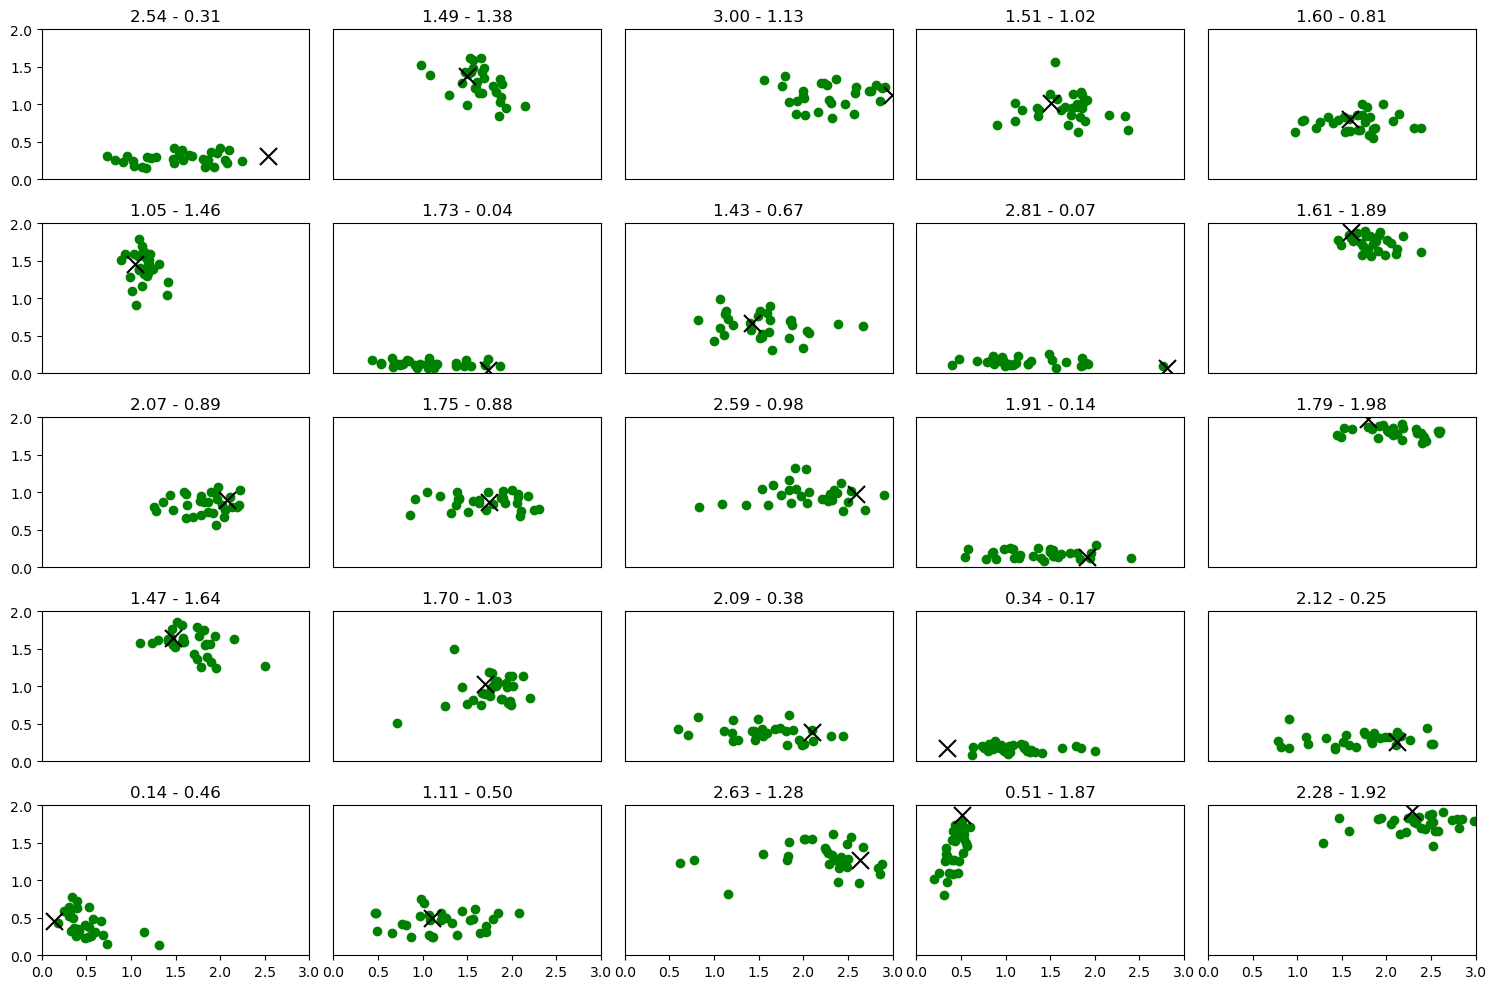

In [16]:
#Brown
pred_tf = pred_tf_full[model==0]
param_tf = param_tf_full[model==0]

fig, axs = plt.subplots(5,5,figsize = (15,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

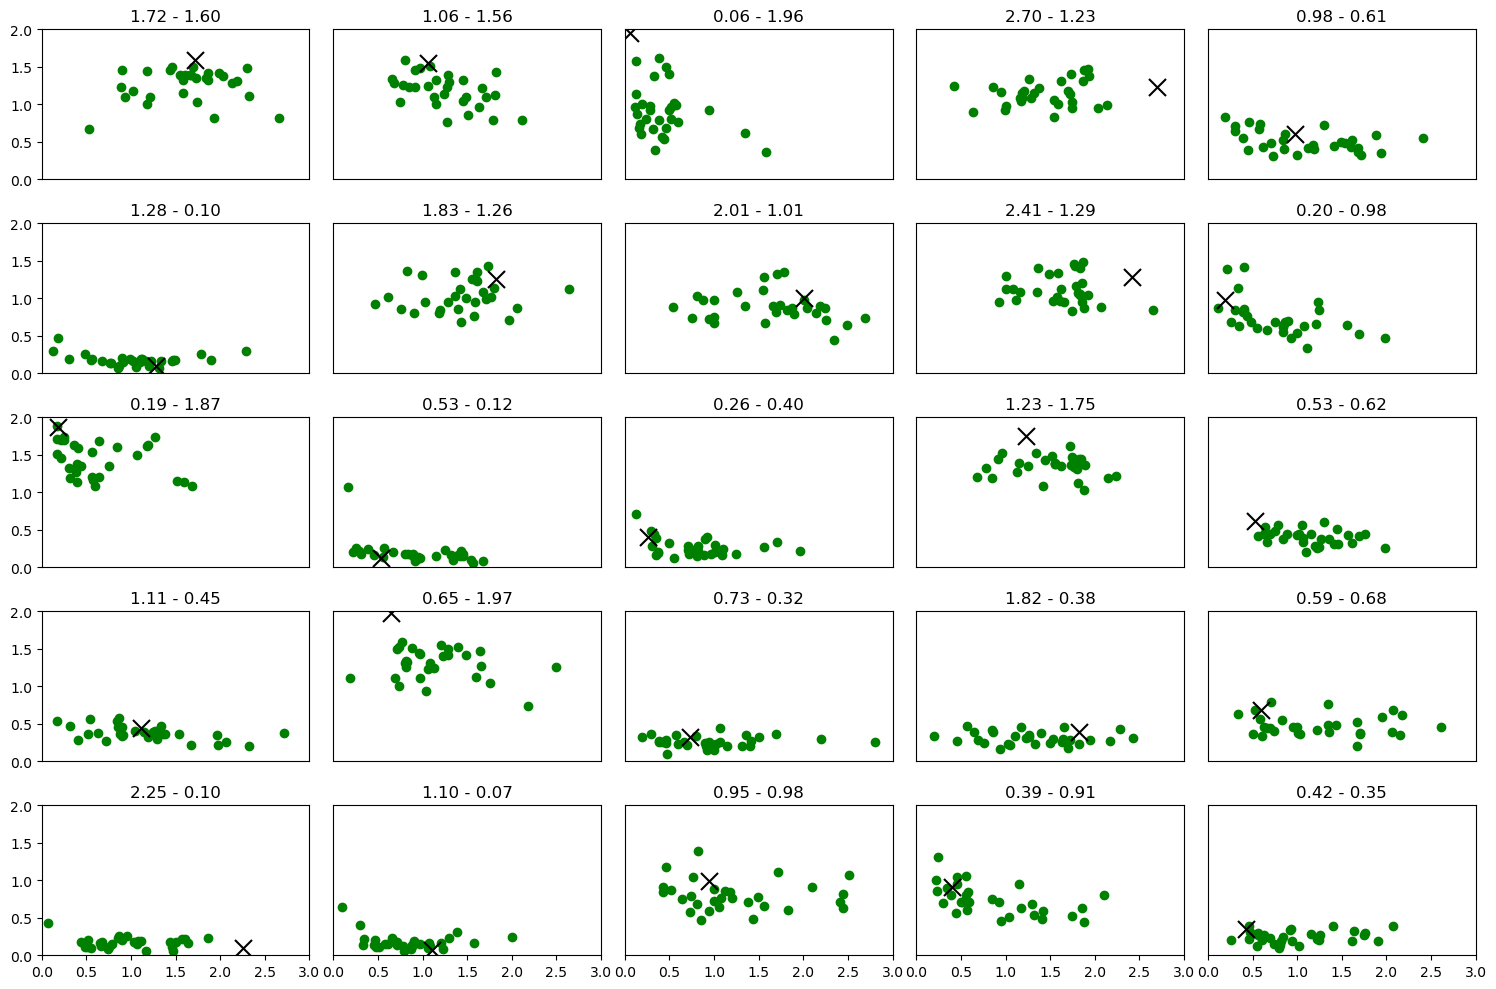

In [14]:
#Powexp
pred_tf = pred_tf_full[model==1]
param_tf = param_tf_full[model==1]

fig, axs = plt.subplots(5,5,figsize = (15,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

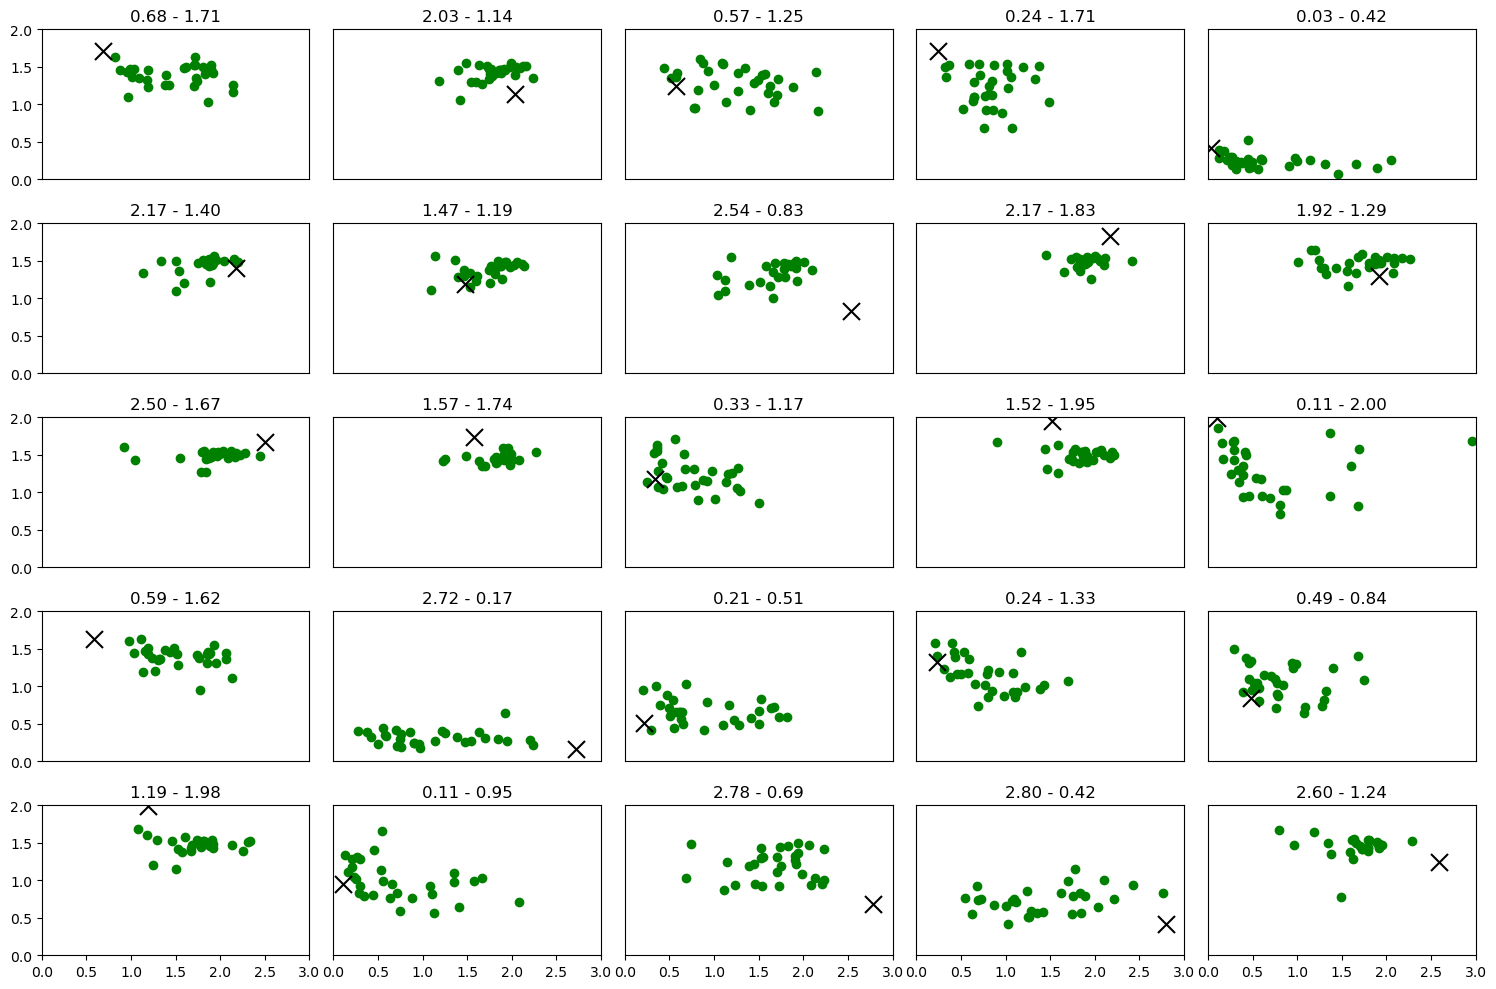

In [15]:
#Whitmat
pred_tf = pred_tf_full[model==2]
param_tf = param_tf_full[model==2]

fig, axs = plt.subplots(5,5,figsize = (15,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()